In [1]:
# main libraries and dependencies
import importlib
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True' # matplotlib on Windows
import torch
from torch import cuda
from scipy.stats import chi2

# Data class contains class indexes
from data_loader import DataClasses

# Diffusion model trainer function
import trainer
# Diffusion model inference function
from inference import generate, get_sr_model_state, get_scheduler, generate_image

# Classificator model
import classificator

# Experiment function
from experiment_runner import generate_classify_and_calculate, classify_and_calculate

# Some useful functions
import helpers

### 0. Print out important system properties

In [2]:
# Check what version of PyTorch is installed
print("PyTorch version: \t", torch.__version__)

# Check if FlashAttention is available
print("FlashAttention: \t", torch.backends.cuda.flash_sdp_enabled())

# Device configuration
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
    # Check total GPU memory and memory used
    gpu_id = 0  # Change for multiple GPUs
    total_memory = torch.cuda.get_device_properties(gpu_id).total_memory
    reserved_memory = torch.cuda.memory_reserved(gpu_id)
    allocated_memory = torch.cuda.memory_allocated(gpu_id)
    free_memory = total_memory - reserved_memory - allocated_memory

    # print the device name
    print("\nDevice name:\t\t", torch.cuda.get_device_properties("cuda").name)
    print("CUDA Version: \t\t", torch.version.cuda)
    print(f"Total GPU memory: \t{total_memory / 1e9:.2f} GB")
    print(f"Reserved memory: \t{reserved_memory / 1e9:.2f} GB")
    print(f"Allocated memory: \t{allocated_memory / 1e9:.2f} GB")
    print(f"Free memory : \t\t{free_memory / 1e9:.2f} GB")

PyTorch version: 	 2.6.0+cu124
FlashAttention: 	 True

Device name:		 NVIDIA RTX A3000 Laptop GPU
CUDA Version: 		 12.4
Total GPU memory: 	6.44 GB
Reserved memory: 	0.00 GB
Allocated memory: 	0.00 GB
Free memory : 		6.44 GB


In [3]:
# Set seed to maintain experiment reproducible
helpers.set_seed(23)

In [4]:
# Paths to files
# Dataset locations
image_dir = 'C:/Users/novit/Documents/datasets/best_alzheimer_mri/train'
test_image_dir = 'C:/Users/novit/Documents/datasets/best_alzheimer_mri/test'
# Location of the generated SR images
gen_image_dir = 'C:/Users/novit/Documents/datasets/best_alzheimer_mri/gen'
# Location to save trained model's weights
ddpm_checkpoint_file = 'ddpm_checkpoints/ddpm_checkpoint_sr.pth'
classificator_checkpoint_file = 'classificator_checkpoints/classificator_checkpoint.pth'
# Location to store statistical data
stats_data_file = 'stats/stat_data.json'

## 1. Diffusion model training process
### 1.1. Setting up training hyperparameters

In [5]:
# Hyperparameters
num_steps = 500
crop_size = 64
batch_size = 32
scale_factor = 2
learning_rate = 2e-5
num_epochs = 50

### 1.2. Run the training process

Dataset size: 40960
Number of classes: 3


Epoch 1/50: 100%|██████████| 1280/1280 [08:42<00:00,  2.45it/s]


Epoch 1 | Loss 0.11596


Epoch 2/50: 100%|██████████| 1280/1280 [08:46<00:00,  2.43it/s]


Epoch 2 | Loss 0.02850


Epoch 3/50: 100%|██████████| 1280/1280 [08:45<00:00,  2.43it/s]


Epoch 3 | Loss 0.02203


Epoch 4/50: 100%|██████████| 1280/1280 [09:06<00:00,  2.34it/s]


Epoch 4 | Loss 0.01859


Epoch 5/50: 100%|██████████| 1280/1280 [09:10<00:00,  2.33it/s]


Epoch 5 | Loss 0.01711


Epoch 6/50: 100%|██████████| 1280/1280 [09:12<00:00,  2.32it/s]


Epoch 6 | Loss 0.01543


Epoch 7/50: 100%|██████████| 1280/1280 [08:42<00:00,  2.45it/s]


Epoch 7 | Loss 0.01432


Epoch 8/50: 100%|██████████| 1280/1280 [08:39<00:00,  2.46it/s]


Epoch 8 | Loss 0.01363


Epoch 9/50: 100%|██████████| 1280/1280 [08:38<00:00,  2.47it/s]


Epoch 9 | Loss 0.01301


Epoch 10/50: 100%|██████████| 1280/1280 [08:38<00:00,  2.47it/s]


Epoch 10 | Loss 0.01227


Epoch 11/50: 100%|██████████| 1280/1280 [08:38<00:00,  2.47it/s]


Epoch 11 | Loss 0.01200


Epoch 12/50: 100%|██████████| 1280/1280 [08:39<00:00,  2.46it/s]


Epoch 12 | Loss 0.01167


Epoch 13/50: 100%|██████████| 1280/1280 [08:39<00:00,  2.46it/s]


Epoch 13 | Loss 0.01158


Epoch 14/50: 100%|██████████| 1280/1280 [08:37<00:00,  2.47it/s]


Epoch 14 | Loss 0.01116


Epoch 15/50: 100%|██████████| 1280/1280 [08:36<00:00,  2.48it/s]


Epoch 15 | Loss 0.01165


Epoch 16/50: 100%|██████████| 1280/1280 [08:36<00:00,  2.48it/s]


Epoch 16 | Loss 0.01132


Epoch 17/50: 100%|██████████| 1280/1280 [08:37<00:00,  2.47it/s]


Epoch 17 | Loss 0.01061


Epoch 18/50: 100%|██████████| 1280/1280 [08:36<00:00,  2.48it/s]


Epoch 18 | Loss 0.01004


Epoch 19/50: 100%|██████████| 1280/1280 [08:36<00:00,  2.48it/s]


Epoch 19 | Loss 0.01084


Epoch 20/50: 100%|██████████| 1280/1280 [08:37<00:00,  2.47it/s]


Epoch 20 | Loss 0.01041


Epoch 21/50: 100%|██████████| 1280/1280 [08:43<00:00,  2.44it/s]


Epoch 21 | Loss 0.01059


Epoch 22/50: 100%|██████████| 1280/1280 [08:42<00:00,  2.45it/s]


Epoch 22 | Loss 0.01048


Epoch 23/50: 100%|██████████| 1280/1280 [08:42<00:00,  2.45it/s]


Epoch 23 | Loss 0.00983


Epoch 24/50: 100%|██████████| 1280/1280 [08:38<00:00,  2.47it/s]


Epoch 24 | Loss 0.01008


Epoch 25/50: 100%|██████████| 1280/1280 [08:37<00:00,  2.47it/s]


Epoch 25 | Loss 0.01019


Epoch 26/50: 100%|██████████| 1280/1280 [08:36<00:00,  2.48it/s]


Epoch 26 | Loss 0.01002


Epoch 27/50: 100%|██████████| 1280/1280 [08:37<00:00,  2.47it/s]


Epoch 27 | Loss 0.00996


Epoch 28/50: 100%|██████████| 1280/1280 [08:37<00:00,  2.47it/s]


Epoch 28 | Loss 0.00992


Epoch 29/50: 100%|██████████| 1280/1280 [08:36<00:00,  2.48it/s]


Epoch 29 | Loss 0.00994


Epoch 30/50: 100%|██████████| 1280/1280 [08:37<00:00,  2.47it/s]


Epoch 30 | Loss 0.00974


Epoch 31/50: 100%|██████████| 1280/1280 [08:37<00:00,  2.47it/s]


Epoch 31 | Loss 0.00981


Epoch 32/50: 100%|██████████| 1280/1280 [08:36<00:00,  2.48it/s]


Epoch 32 | Loss 0.00924


Epoch 33/50: 100%|██████████| 1280/1280 [08:37<00:00,  2.47it/s]


Epoch 33 | Loss 0.00953


Epoch 34/50: 100%|██████████| 1280/1280 [08:37<00:00,  2.48it/s]


Epoch 34 | Loss 0.00992


Epoch 35/50: 100%|██████████| 1280/1280 [08:36<00:00,  2.48it/s]


Epoch 35 | Loss 0.00929


Epoch 36/50: 100%|██████████| 1280/1280 [08:36<00:00,  2.48it/s]


Epoch 36 | Loss 0.00920


Epoch 37/50: 100%|██████████| 1280/1280 [08:35<00:00,  2.48it/s]


Epoch 37 | Loss 0.00932


Epoch 38/50: 100%|██████████| 1280/1280 [08:35<00:00,  2.48it/s]


Epoch 38 | Loss 0.00980


Epoch 39/50: 100%|██████████| 1280/1280 [08:35<00:00,  2.48it/s]


Epoch 39 | Loss 0.00955


Epoch 40/50: 100%|██████████| 1280/1280 [08:36<00:00,  2.48it/s]


Epoch 40 | Loss 0.00899


Epoch 41/50: 100%|██████████| 1280/1280 [08:37<00:00,  2.47it/s]


Epoch 41 | Loss 0.00927


Epoch 42/50: 100%|██████████| 1280/1280 [08:37<00:00,  2.47it/s]


Epoch 42 | Loss 0.00960


Epoch 43/50: 100%|██████████| 1280/1280 [08:37<00:00,  2.47it/s]


Epoch 43 | Loss 0.00888


Epoch 44/50: 100%|██████████| 1280/1280 [08:36<00:00,  2.48it/s]


Epoch 44 | Loss 0.00884


Epoch 45/50: 100%|██████████| 1280/1280 [08:36<00:00,  2.48it/s]


Epoch 45 | Loss 0.00960


Epoch 46/50: 100%|██████████| 1280/1280 [08:35<00:00,  2.48it/s]


Epoch 46 | Loss 0.00934


Epoch 47/50: 100%|██████████| 1280/1280 [08:35<00:00,  2.48it/s]


Epoch 47 | Loss 0.00921


Epoch 48/50: 100%|██████████| 1280/1280 [08:36<00:00,  2.48it/s]


Epoch 48 | Loss 0.00928


Epoch 49/50: 100%|██████████| 1280/1280 [08:35<00:00,  2.48it/s]


Epoch 49 | Loss 0.00947


Epoch 50/50: 100%|██████████| 1280/1280 [08:36<00:00,  2.48it/s]


Epoch 50 | Loss 0.00911


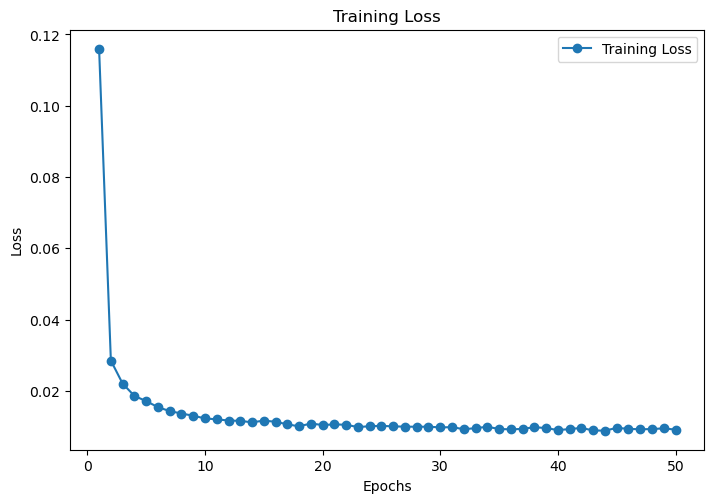

In [6]:
cuda.empty_cache()
trainer.train_sr(
    image_dir=image_dir,
    crop_size=crop_size,
    scale_factor=scale_factor,
    batch_size=batch_size,
    lr=learning_rate,
    num_time_steps=num_steps,
    num_epochs=num_epochs,
    # checkpoint_path='ddpm_checkpoints/ddpm_checkpoint_sr.pth',
    file_to_save=ddpm_checkpoint_file,
)

### 1.3. Run the inference to produce super-resolved images

In [7]:
# Load some images from dataset to make inference
crop_size = 128
num_images = 10  # number images to load
# Load and log the first 10 elements from the DataLoader
# lrs - Low-resolution images list
# hrs - Hi-resolution images list
# clss - List of ground true class of images
lrs, hrs, clss, _ = helpers.image_loader(
    image_dir=test_image_dir,
    num_images=num_images,
    crop_size=crop_size,
    scale_factor=scale_factor,
)

In [8]:
# Images to show (up to 10)
num_images = 3
assert len(lrs) >= num_images, 'Up to {len(lrs)} images can be shown!'
# loading saved model weight
# model = get_sr_model_state('ddpm_checkpoints/ddpm_checkpoint_sr_1750339897.472253', num_classes=5)
model = get_sr_model_state(ddpm_checkpoint_file, num_classes=3)
# creating scheduler
scheduler = get_scheduler(num_steps)
generated_images = []
# Get "null" class for guideless inference
null_class = torch.tensor([DataClasses.get_null_class_index(DataClasses)])
# generating image examples (will take some time)
for idx in range(num_images):
    generated_image = generate_image(128, lrs[idx], null_class, model, scheduler, num_steps)
    generated_images.append(generated_image)
    cuda.empty_cache()


### 1.4 Show images side-by-side: low-res, hi-res, bicubic upscaled low-res and super-res

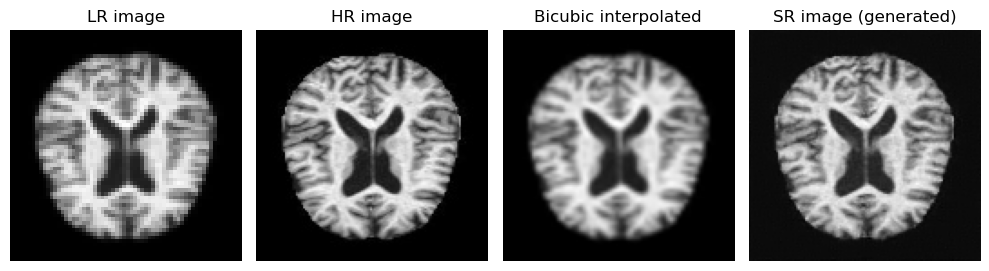

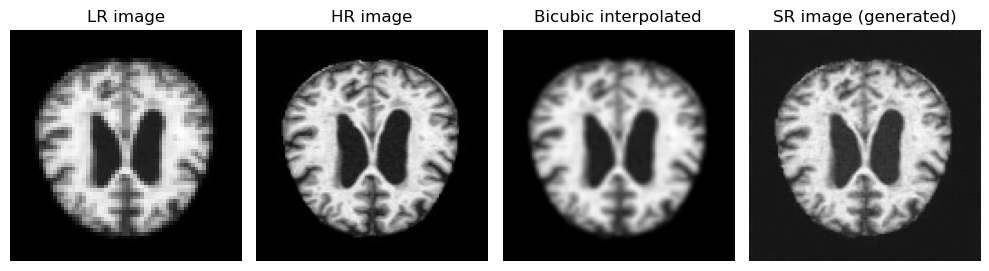

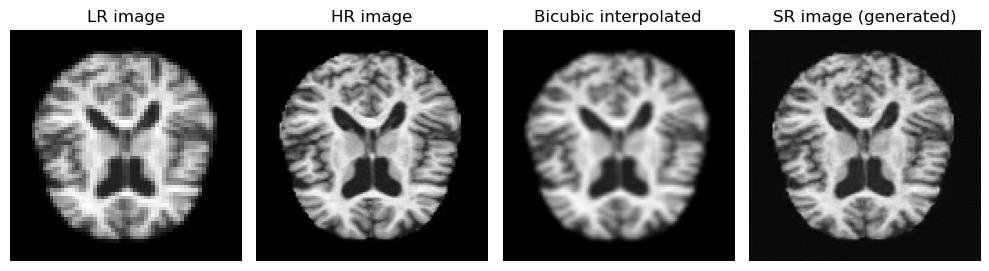

In [9]:
# display generated SR images
for idx in range(num_images):
    helpers.show_images(lrs[idx], hrs[idx], generated_images[idx].squeeze(0))

## 2. Classificator model training process
### 2.1. Set up training hyperparameters

In [10]:
cuda.empty_cache()
# Hyperparameters
batch_size = 256
learning_rate = 0.00001
num_epochs = 35 # 35 is optimal for alzheimer dataset
crop_size = 128

### 2.2. Running the training process

No pre-trained model found or path not specified. Starting training from scratch.
Epoch [1/35], Train Loss: 0.5048, Train Accuracy: 0.7621, Valid Loss: 0.7209, Valid Accuracy: 0.5246, 
Epoch [2/35], Train Loss: 0.3564, Train Accuracy: 0.8597, Valid Loss: 0.5783, Valid Accuracy: 0.6943, 
Epoch [3/35], Train Loss: 0.2985, Train Accuracy: 0.8758, Valid Loss: 0.5285, Valid Accuracy: 0.7279, 
Epoch [4/35], Train Loss: 0.2563, Train Accuracy: 0.8971, Valid Loss: 0.4961, Valid Accuracy: 0.7584, 
Epoch [5/35], Train Loss: 0.2203, Train Accuracy: 0.9149, Valid Loss: 0.4608, Valid Accuracy: 0.7725, 
Epoch [6/35], Train Loss: 0.1884, Train Accuracy: 0.9313, Valid Loss: 0.4381, Valid Accuracy: 0.7881, 
Epoch [7/35], Train Loss: 0.1590, Train Accuracy: 0.9445, Valid Loss: 0.4224, Valid Accuracy: 0.8108, 
Epoch [8/35], Train Loss: 0.1331, Train Accuracy: 0.9610, Valid Loss: 0.3997, Valid Accuracy: 0.8147, 
Epoch [9/35], Train Loss: 0.1080, Train Accuracy: 0.9696, Valid Loss: 0.3775, Valid Accuracy: 

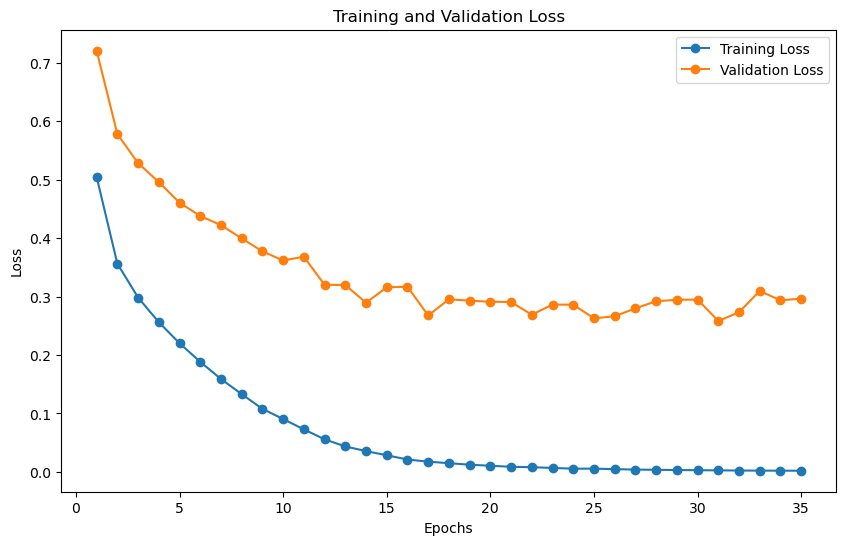

In [11]:
classificator.trainer(
    train_image_dir=image_dir,
    val_image_dir=test_image_dir,
    num_epochs=num_epochs,
    batch_size=batch_size,
    crop_size=crop_size,
    learning_rate=learning_rate,
    device=device,
    file_to_save=classificator_checkpoint_file,
)

### 2.3. Run classificator to evaluate previously generated images

In [12]:
# Loading saved classificator's weights and instantiating classificator instance
# classificator_checkpoint_path = 'classifier_models\\classification_model1750175641.079124.pth'
model = classificator.get_model_state(classificator_checkpoint_file, num_classes=2)
# evaluating images previously generated by diffusion model in 1.3.
predicted_cls_idxs = []
for idx in range(num_images):
    predicted_cls_idxs.append(classificator.classify_image(model, generated_images[idx]))
for idx in range(num_images):
    print(f'Image true class: {clss[idx][0]} \tGenerated image predicted class: {predicted_cls_idxs[idx]}')

Image true class: 0 	Generated image predicted class: 0
Image true class: 0 	Generated image predicted class: 1
Image true class: 0 	Generated image predicted class: 0


## 3. Experiment
### 3.1. Set parameters

In [13]:
# Paths to files - repeated for convenience
# Dataset locations
test_image_dir = 'C:/Users/novit/Documents/datasets/best_alzheimer_mri/test'
# Location of the generated SR images
gen_image_dir = 'C:/Users/novit/Documents/datasets/best_alzheimer_mri/gen'
# Location to save trained model's weights
ddpm_checkpoint_file = 'ddpm_checkpoints/ddpm_checkpoint_sr.pth'
classificator_checkpoint_file = 'classificator_checkpoints/classificator_checkpoint.pth'
# Location to store statistical data
stats_data_file = 'stats/stat_data.json'

### 3.2. Run experiment to generate and classify images

In [13]:
# Generate SR images from the test LR ones and save them
generate(test_image_dir, gen_image_dir, ddpm_checkpoint_file)

source_image_path:  C:/Users/novit/Documents/datasets/best_alzheimer_mri/test
Number of images: 		1279
Number of images to generate: 	1279
Finished generating images. Generated 1279 images, 100.00


In [16]:
stats_data = classify_and_calculate(test_image_dir, gen_image_dir, classificator_checkpoint_file, save_path=stats_data_file)

Processing test dataset: 100%|██████████| 1279/1279 [00:23<00:00, 54.89it/s]


### 3.3. Display achieved metrics

In [17]:
# Read saved statistical data object
try:
    stats_data
except NameError:
    stats_data = helpers.load_json(stats_data_file)

# unpack statistical data from data object
mcnemar_stats = stats_data['mcnemar_stats']

base_stats_data = stats_data['base_stats_data']
is_correct_predictions = stats_data['is_correct_predictions']

# true image classes
image_classes = base_stats_data['image_classes']
# predicted true image class
ground_truth_predictions = base_stats_data['ground_truth_predictions']
# predicted generated image class
generated_predictions = base_stats_data['generated_predictions']

# Two sets of images predicted classification
is_correct_ground_true_predictions = is_correct_predictions['is_correct_ground_true_predictions']
is_correct_generated_predictions = is_correct_predictions['is_correct_generated_predictions']


#### 3.3.1 Contingency table for McNemar test

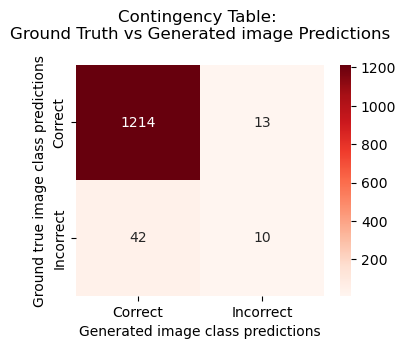

In [18]:
importlib.reload(helpers)
ct_df = helpers.show_conf_matrix(
    is_correct_ground_true_predictions,
    is_correct_generated_predictions,
    title='Contingency Table: \nGround Truth vs Generated image Predictions\n',
    indexes=['Correct', 'Incorrect'],
    columns=['Correct', 'Incorrect'],
    xlabel='Generated image class predictions',
    ylabel='Ground true image class predictions',
    color='Reds'
)

In [19]:
# Access the values from the DataFrame
a = ct_df.loc['Correct', 'Correct']
b = ct_df.loc['Correct', 'Incorrect']
c = ct_df.loc['Incorrect', 'Correct']
d = ct_df.loc['Incorrect', 'Incorrect']
# Printing variables for calculate McNemar chi2
print(f"a: {a}")
print(f"b: {b}")
print(f"c: {c}")
print(f"d: {d}")

a: 1214
b: 13
c: 42
d: 10


#### 3.3.2 McNemar chi-squared and p-value

In [20]:
# Perform the McNemar test
result = (b-c)**2/(b+c)

# Table dimensionality
rows, cols = ct_df.shape

# Calculate degree of freedom
degree_of_freedom = (rows - 1)*(cols - 1)

# Calculate p-value from the chi-squared statistic
p_value = chi2.sf(result, df=degree_of_freedom)

print("McNemar's Test Results:")
print(f"Chi-squared statistic: \t{result:.3f}")
print(f"P-value: \t\t\t\t{p_value}")

McNemar's Test Results:
Chi-squared statistic: 	15.291
P-value: 				9.215896806326964e-05


#### 3.3.3 Confusion matrix and metrics for Ground true image classifications

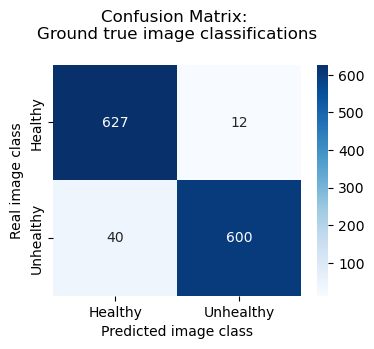

In [21]:
true_cm_df = helpers.show_conf_matrix(
    image_classes,
    ground_truth_predictions,
    title='Confusion Matrix: \nGround true image classifications\n',
    indexes=['Healthy', 'Unhealthy'],
    columns=['Healthy', 'Unhealthy'],
    xlabel='Predicted image class',
    ylabel='Real image class',
)

In [22]:
# Access the values from the DataFrame
TN = true_cm_df.loc['Healthy', 'Healthy']
FP = true_cm_df.loc['Healthy', 'Unhealthy']
FN = true_cm_df.loc['Unhealthy', 'Healthy']
TP = true_cm_df.loc['Unhealthy', 'Unhealthy']

print(f"True Positives (TP): \t{TP}")
print(f"False Negatives (FN): \t{FN}")
print(f"False Positives (FP): \t{FP}")
print(f"True Negatives (TN): \t{TN}")

True Positives (TP): 	600
False Negatives (FN): 	40
False Positives (FP): 	12
True Negatives (TN): 	627


In [23]:
accuracy = (TP+TN)/(TP+TN+FP+FN)
precision = TP/(TP+FP)
recall = TP/(TP+FN)
FNR = FN/(TN+FP)

print(f"True image classification metrics:")
print(f"  Accuracy: \t{accuracy:.3f}")
print(f"  Precision: \t{precision:.3f}")
print(f"  Recall: \t\t{recall:.3f}")
print(f"  FNR: \t\t\t{FNR:.3f}")

True image classification metrics:
  Accuracy: 	0.959
  Precision: 	0.980
  Recall: 		0.938
  FNR: 			0.063


#### 3.3.4 Confusion matrix and metrics for Generated image classifications

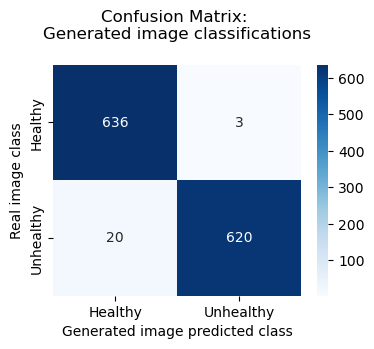

In [24]:
# Generated image classification confusion matrix
gen_cm_df = helpers.show_conf_matrix(
    image_classes,
    generated_predictions,
    title='Confusion Matrix: \nGenerated image classifications\n',
    indexes=['Healthy', 'Unhealthy'],
    columns=['Healthy', 'Unhealthy'],
    xlabel='Generated image predicted class',
    ylabel='Real image class',
)

In [25]:
# Access the values from the DataFrame
TN = gen_cm_df.loc['Healthy', 'Healthy']
FP = gen_cm_df.loc['Healthy', 'Unhealthy']
FN = gen_cm_df.loc['Unhealthy', 'Healthy']
TP = gen_cm_df.loc['Unhealthy', 'Unhealthy']

print(f"True Positives (TP): \t{TP}")
print(f"False Negatives (FN): \t{FN}")
print(f"False Positives (FP): \t{FP}")
print(f"True Negatives (TN): \t{TN}")

True Positives (TP): 	620
False Negatives (FN): 	20
False Positives (FP): 	3
True Negatives (TN): 	636


In [26]:
accuracy = (TP+TN)/(TP+TN+FP+FN)
precision = TP/(TP+FP)
recall = TP/(TP+FN)
FNR = FN/(TN+FP)

print(f"Generated image classification metrics:")
print(f"  Accuracy: \t{accuracy:.3f}")
print(f"  Precision: \t{precision:.3f}")
print(f"  Recall: \t\t{recall:.3f}")
print(f"  FNR: \t\t\t{FNR:.3f}")

Generated image classification metrics:
  Accuracy: 	0.982
  Precision: 	0.995
  Recall: 		0.969
  FNR: 			0.031
